In [1]:
from collections import namedtuple
import math

class P3(namedtuple('P3', ['x', 'y', 'z'])):
    __slots__ = ()
    def __new__(self, x, y, z):
        return super(P3, self).__new__(self, float(x), float(y), float(z))
    def __repr__(self):
        return "P3(%s, %s, %s)" % (self.x, self.y, self.z)
    def __add__(self, a):
        return P3(self.x + a.x, self.y + a.y, self.z + a.z)
    def __sub__(self, a):
        return P3(self.x - a.x, self.y - a.y, self.z - a.z)
    def __mul__(self, a):
        return P3(self.x*a, self.y*a, self.z*a)
    def __neg__(self):
        return P3(-self.x, -self.y, -self.z)
    def __rmul__(self, a):
        raise TypeError
    def Lensq(self):
        return self.x*self.x + self.y*self.y + self.z*self.z
    def Len(self):
        return math.sqrt(self.Lensq())
    def LenLZ(self):
        return math.sqrt(self.x*self.x + self.y*self.y)
        
        
    def assertlen1(self):
        assert abs(self.Len() - 1.0) < 0.0001
        return True
        
    @staticmethod
    def Dot(a, b):
        return a.x*b.x + a.y*b.y + a.z*b.z

    @staticmethod
    def Cross(a, b):
        return P3(a.y*b.z - b.y*a.z, -a.x*b.z + b.x*a.z, a.x*b.y - b.x*a.y)


In [23]:
# ab is the triangle edge axis, d is crossing point on axis coming from c
# e is point of triangle to right of axis
Ga = P3(0,0,0)
Gb = P3(0,1,0)
lam = 0.31
Gc = P3(-1,0.3,0)
Ge = P3(1,0.5,0)


In [283]:
# axis is a b
# incoming at d = Along(lam, a, b)
# incoming from c to d 
# incoming (d - c).(b - a) = |d-c||b-a|cos(theta) = |d-c|I
# I = |b-a|cos(theta) = (d - c).(b - a)/|d-c|

# triangle on right hand side is to e
# outgoing to x where x = Along(q, a, e) or x = Along(q, b, e)
# Solve (x - d).(b - a) = |x-d||b-a|cos(theta) = |x-d|I

# Set d = 0, v = b - a
# x.v = |x|I  where x = a + (e - a)*q = a + f*q
# x.x I^2 = (x.v)^2

# x.x I^2 = (a + f*q)^2 I^2 = q^2 f^2 I^2 + 2q a.f I^2 + a^2 I^2
#   =
# (x.v)^2 = (a.v + f.v*q)^2 = q^2 (f.v)^2 + 2q (a.v)(f.v) + (a.v)^2
# q^2 ((f.v)^2 - f^2 I^2) + 2q ((a.v)(f.v) - a.f I^2) + (a.v)^2 - a^2 I^2

def Square(X):
    return X*X
def TOL_ZERO(X):
    if not (abs(X) < 0.0001):
        print("TOL_ZERO fail", X)

def GeoCrossAxisE(a, Vae, Vab, Isq, Isgn):
    # Solve: Isq*x.Lensq() - Square(P3.Dot(x, Vab)) = 0   for x = a + Vae*q
    # 0 = Isq*(a^2 + 2q a.Vae + q^2 Vae^2) - (a.Vab + Vae.Vab q)^2
    #   = Isq*(a^2 + 2q adf + q^2 Vae^2) - (adv + fdv q)^2

    fdv = P3.Dot(Vae, Vab)
    adv = P3.Dot(a, Vab)
    adf = P3.Dot(a, Vae)
    qA = Square(fdv) - Vae.Lensq()*Isq
    qB2 = adv*fdv - adf*Isq
    qC = Square(adv) - a.Lensq()*Isq
    if abs(qA) < abs(qB2)*1e-7:
        q = -qC/(2*qB2)
    else:
        qdq = Square(qB2) - qA*qC
        if qdq < 0.0:
            #print("qdq", qdq)
            return -1.0
        qs = math.sqrt(qdq) / qA
        qm = -qB2 / qA
        q = qm + qs*Isgn
    # q = qs +- qm,  x = a + Vae*q,  Dot(x, Vab) same sign as Dot(Vcd, Vab)
    if abs(q) < 100:
        TOL_ZERO(qA*Square(q) + qB2*2*q + qC)
    return q

def GeoCrossAxis(Ga, Gb, Gc, lam, Ge):
    Vab = Gb - Ga
    Gd = Ga + Vab*lam
    Vcd = Gd - Gc
    cdDab = P3.Dot(Vcd, Vab)
    Isq = Square(cdDab) / Vcd.Lensq()
    Isgn = -1 if cdDab < 0 else 1
    qVae = GeoCrossAxisE(Ga - Gd, Ge - Ga, Vab, Isq, Isgn)
    qVbe = GeoCrossAxisE(Gb - Gd, Ge - Gb, -Vab, Isq, -Isgn)
    bAEcrossing = (abs(qVae - 0.5) < abs(qVbe - 0.5))
    q = qVae if bAEcrossing else qVbe
    Gx = (Ga + (Ge - Ga)*q) if bAEcrossing else (Gb + (Ge - Gb)*q)
    Dx = Gx - Gd
    TOL_ZERO(Isq - Square(P3.Dot(Dx, Vab)/Dx.Len()))
    TOL_ZERO(P3.Dot(Vcd, Vab)/Vcd.Len() - P3.Dot(Dx, Vab)/Dx.Len())
    return bAEcrossing, q, Gx
    

# simplified counterexample fail!

(Ga, Gb, Gc, lam, Ge) = (P3(0.0, 0.0, 0), 
                         P3(0.9081781600067014, -1.25, 0), 
                         P3(0.7245938674784592, -1.3, 0), 
                         0.7978543191053091, 
                         P3(1.4694631307311832, -0.47745751406263137, 0))

Gd = Ga + (Gb - Ga)*lam
print(Gd, Gc-Gd)
GeoCrossAxis(Ga, Gb, Gc, lam, Ge)


P3(0.7245938674784592, -0.9973178988816365, 0.0) P3(0.0, -0.3026821011183636, 0.0)


(True, 0.4931010872779853, P3(0.7245938674784587, -0.2354348193133275, 0.0))

In [124]:
print(Ga)
print(Gb)
print(Gc)
print(Ge)

P3(-1.7274575140626311, -2.3776412907378845, -4.045084971874737)
P3(3.599146639029983e-16, -2.938926261462366, -4.045084971874737)
P3(-2.3776412907378837, -3.272542485937369, -2.938926261462366)
P3(1.8921833652170753e-16, -1.5450849718747373, -4.755282581475767)


In [35]:
import sys
sys.path.append("/home/julian/repositories")
sys.path.append("/home/julian/repositories/barmesh")
from barmesh.tribarmes import TriangleBarMesh


In [323]:
import math
def GenerateSphere(rad, N, M):
    longs = [ math.radians(i/N*360.0)  for i in range(N) ]
    lats = [ math.radians(i/M*180.0 - 90.0)  for i in range(M+1) ]
    rpts = [ P3(0,0,-rad)  for i in range(N) ]
    flat9triangles = [ ]
    for i in range(1, M+1):
        lat = math.radians(i/M*180.0 - 90.0)
        sinlat = math.sin(lat) if i != M else 1
        coslat = math.cos(lat) if i != M else 0
        rptsN = [ P3(coslat*math.sin(lng), coslat*math.cos(lng), sinlat)*rad  for lng in longs ]
        rp0, rpN0 = rpts[-1], rptsN[-1]
        for rp, rpN in zip(rpts, rptsN):
            if i != 1:
                flat9triangles.append(tuple(rp0)+tuple(rp)+tuple(rpN))
            if i != M:
                flat9triangles.append(tuple(rp0)+tuple(rpN)+tuple(rpN0))
            rp0, rpN0 = rp, rpN
        rpts = rptsN
    return flat9triangles


flat9triangles = GenerateSphere(5, 10, 10)
tbm = TriangleBarMesh(flat9triangles=flat9triangles)
tbm = TriangleBarMesh("/home/julian/repositories/HGnotebooks/Sphere-medium.stl")


162

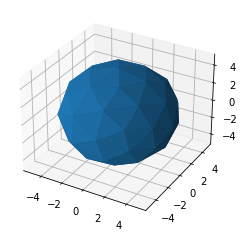

In [325]:
#tbm = TriangleBarMesh(flat9triangles=flat9triangles)
tris = tbm.GetBarMeshTriangles()

X = numpy.array(sum(((tri[0][0], tri[1][0], tri[2][0])  for tri in tris), start=()))
Y = numpy.array(sum(((tri[0][1], tri[1][1], tri[2][1])  for tri in tris), start=()))
Z = numpy.array(sum(((tri[0][2], tri[1][2], tri[2][2])  for tri in tris), start=()))
triangles = [ [i,i+1,i+2]  for i in range(0, len(X), 3)]

ax = plt.axes(projection='3d')
ax.plot_trisurf(X, Y, Z, triangles=triangles, linewidths=0.2);
len(tbm.bars)

In [300]:

def GeoCrossBar(c, bar, lam):
    Na, Nb = bar.nodeback, bar.nodefore
    Ne = bar.barforeright.GetNodeFore(bar.barforeright.nodeback == bar.nodefore)
    d = Na.p + (Nb.p - Na.p)*lam
    #print("\n", Na.p, Nb.p, c, lam, Ne.p)
    bAEcrossing, q, Gx = GeoCrossAxis(Na.p, Nb.p, c, lam, Ne.p)
    if bAEcrossing:
        bar = bar.barforeright.GetForeRightBL(bar.barforeright.nodeback == Nb)
        lam = q if bar.nodeback == Na else 1-q
    else:
        bar = bar.barforeright
        lam = q if bar.nodeback == Nb else 1-q
    c = bar.nodeback.p + (bar.nodefore.p - bar.nodeback.p)*lam
    TOL_ZERO((c - Gx).Len())
    return (d, bar, lam)




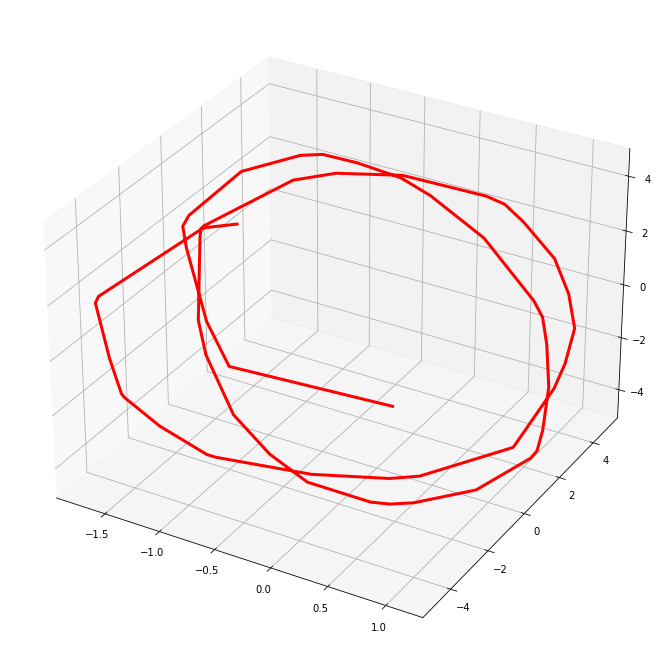

In [327]:
bar = tbm.bars[100]
Nc = bar.barbackleft.GetNodeFore(bar.barbackleft.nodeback == bar.nodeback)
lam = 0.4
c = Nc.p + P3(0,0,0.02)
geoseq = [ ]
for i in range(60):
    c, bar, lam = GeoCrossBar(c, bar, lam)
    geoseq.append(c)
    
plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
#ax.plot_trisurf(X, Y, Z+8, triangles=triangles, linewidths=0.2);
xs, ys, zs = [ p[0]  for p in geoseq ], [ p[1]  for p in geoseq ], [ p[2]  for p in geoseq ]
ax.plot(xs, ys, zs, color="red", linewidth=3);

